Found 0.0 in 2024-06-02T03:54-dynamic_48_0_0.txt
Found 0.05 in 2024-06-02T04:17-dynamic_48_0_05.txt
Found 0.2 in 2024-06-02T04:42-dynamic_48_0_2.txt
Found 0.4 in 2024-06-02T05:07-dynamic_48_0_4.txt
Found 0.6 in 2024-06-02T05:32-dynamic_48_0_6.txt
Found 0.8 in 2024-06-02T05:58-dynamic_48_0_8.txt
Found 1.0 in 2024-06-02T06:24-dynamic_48_1_0.txt
Found 0.0 in 2024-06-02T06:50-dynamic_48_0_0.txt
Found 0.05 in 2024-06-02T07:14-dynamic_48_0_05.txt
Found 0.2 in 2024-06-02T07:38-dynamic_48_0_2.txt
Found 0.4 in 2024-06-02T08:03-dynamic_48_0_4.txt
Found 0.6 in 2024-06-02T08:29-dynamic_48_0_6.txt
Found 0.8 in 2024-06-02T08:55-dynamic_48_0_8.txt
Found 1.0 in 2024-06-02T09:21-dynamic_48_1_0.txt
Found 0.0 in 2024-06-02T09:47-dynamic_48_0_0.txt
Found 0.05 in 2024-06-02T10:11-dynamic_48_0_05.txt
Found 0.2 in 2024-06-02T10:35-dynamic_48_0_2.txt
Found 0.4 in 2024-06-02T11:01-dynamic_48_0_4.txt
Found 0.6 in 2024-06-02T11:26-dynamic_48_0_6.txt
Found 0.8 in 2024-06-02T11:52-dynamic_48_0_8.txt
Found 1.0 in 2

/Users/santiago/projects/decentralizepy/.venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/santiago/projects/decentralizepy/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


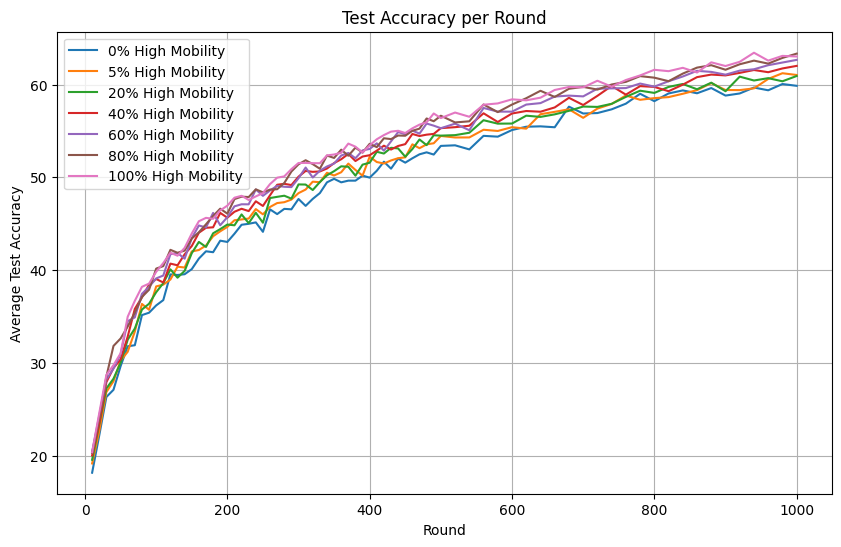

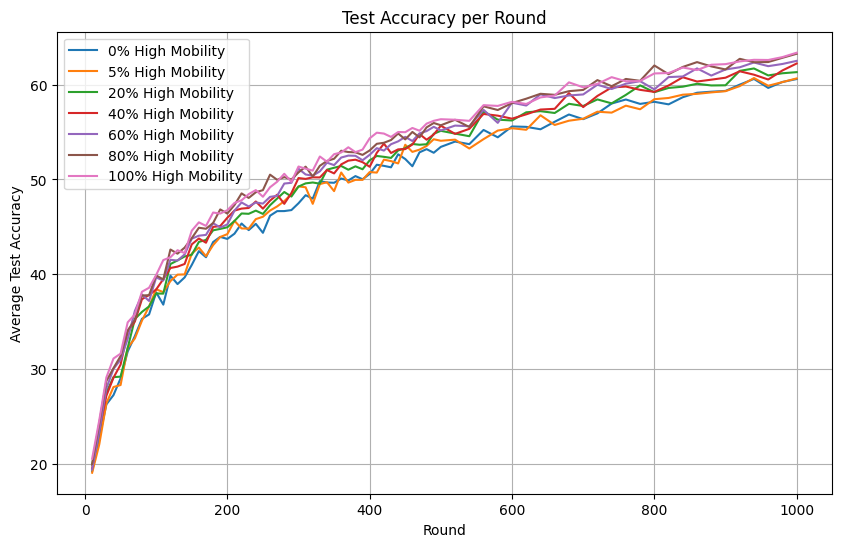

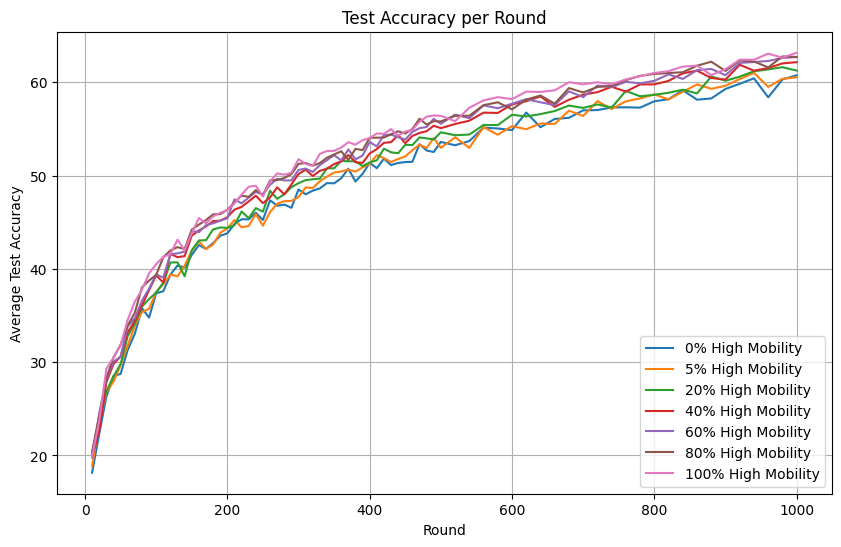

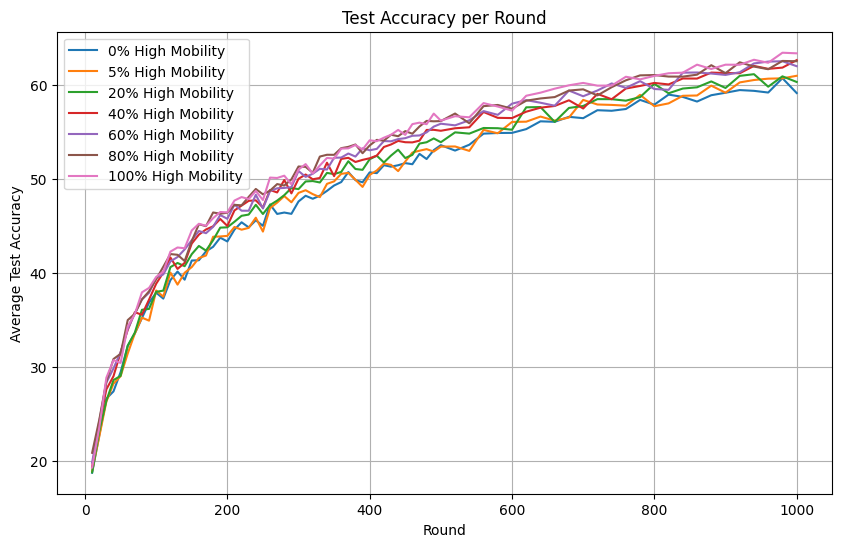

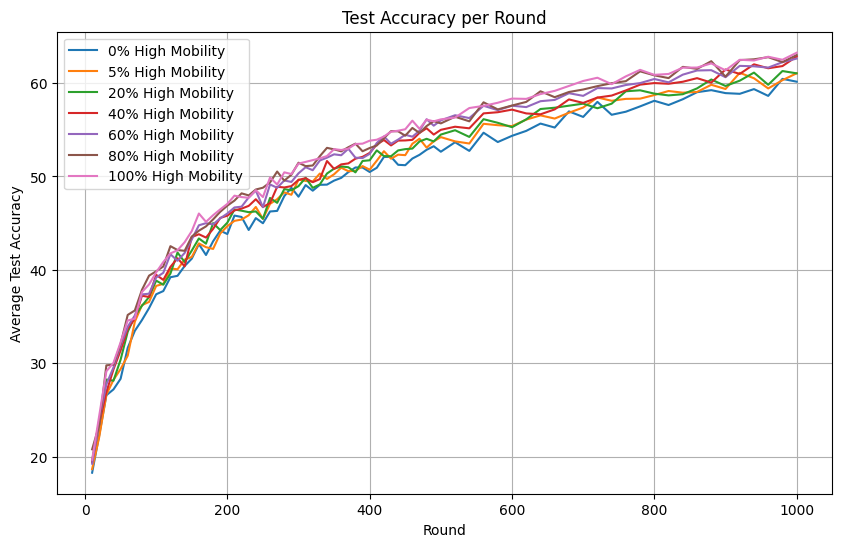

In [82]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt    
from collections import defaultdict


def average_of_first_percent(lst, p):
    n = int(len(lst) * p)
    return np.mean(lst[:n])

def average_of_last_percent(lst, p):
    n = int(len(lst) * p)
    return np.mean(lst[-n:])

def find_data_dir_with_mobility(base_dir: str, mobility: float):
    mobility_str = str(mobility).replace(".", "_") + ".txt"
    for dir in os.listdir(base_dir):
        if mobility_str in dir:
            print(f"Found {mobility} in {dir}")
            return os.path.join(base_dir, dir, "machine0")
    
    print(f"Could not find mobility {mobility} in {base_dir}")
    raise ValueError

def inf_dict():
    return defaultdict(inf_dict)

num_nodes = 48
experiment_groups ={
    1: ".saved_experiments/2024-06-02-corr-neighbours-1",
    2: ".saved_experiments/2024-06-02-corr-neighbours-2",
    3: ".saved_experiments/2024-06-02-corr-neighbours-3",
    4: ".saved_experiments/2024-06-02-corr-neighbours-4",
    5: ".saved_experiments/2024-06-02-corr-neighbours-5",
}
mobility_aware = False
experiments = {
    0.0: "0% High Mobility",
    0.05: "5% High Mobility",
    0.2: "20% High Mobility",
    0.4: "40% High Mobility",
    0.6: "60% High Mobility",
    0.8: "80% High Mobility",
    1.0: "100% High Mobility",
}
statistics = ["test_acc"]

def load_experiment_data(experiment_data, base_dir):
    for experiment, _ in experiments.items():
        experiment_data[experiment] = {}
        dir = find_data_dir_with_mobility(base_dir, experiment)
        for i in range(num_nodes):
            file_path = os.path.join(dir, f"{i}_results.json")
            if os.path.exists(file_path):
                with open(file_path, "r") as file:
                    content = json.load(file)

                    for statistic, rounds in content.items():
                        if statistic not in experiment_data[experiment]:
                            experiment_data[experiment][statistic] = {}

                        for round, value in rounds.items():
                            round = int(round)
                            if round not in experiment_data[experiment][statistic]:
                                experiment_data[experiment][statistic][round] = []
                            experiment_data[experiment][statistic][round].append(value)

def compute_experiment_averages(experiment_data, statistics):
    averages = inf_dict()
    high_mobility_averages = inf_dict() 
    low_mobility_averages = inf_dict()
    for experiment in experiment_data:
        averages[experiment] = inf_dict()
        for statistic in statistics:
            for round, values in experiment_data[experiment][statistic].items():
                averages[experiment][statistic][round] = np.mean(values)

                if round == "10":
                    print(values)
                    print(len(values))

                high_mobility_proportion = experiment
                low_mobility_proportion = 1 - experiment
                high_mobility_averages[experiment][statistic][round] = average_of_first_percent(values, high_mobility_proportion)
                low_mobility_averages[experiment][statistic][round] = average_of_last_percent(values, low_mobility_proportion)
    return averages, high_mobility_averages, low_mobility_averages

def plot_averages(experiment_names, averages, experiment_group="", save_fig=False, new_fig=True, show=True):
    if new_fig:
        plt.figure(figsize=(10, 6))

    for experiment, _ in averages.items():
        for statistic in statistics:
            rounds, acc_values = zip(*averages[experiment][statistic].items())
            plt.plot(rounds, acc_values, label=f"{experiment_names[experiment]}")

    plt.xlabel("Round")
    plt.ylabel("Average Test Accuracy")
    plt.title(f"Test Accuracy per Round")
    plt.legend()
    plt.grid(True)
    if save_fig:
        plt.savefig(f"saved_figures/test_accuracy_group_{[str(s) for s in experiments]}_{experiment_group}_mobility_aware_{mobility_aware}.pdf")
    if show:
        plt.show()


grouped_experiments_data = inf_dict()
for experiment_group, dir in experiment_groups.items():
    experiment_data = grouped_experiments_data[experiment_group]
    load_experiment_data(experiment_data, dir)

grouped_averages = inf_dict()
grouped_high_mobility_averages = inf_dict()
grouped_low_mobility_averages = inf_dict()
for experiment_group, experiment_data in grouped_experiments_data.items():
    averages, high_mobility_averages, low_mobility_averages = compute_experiment_averages(experiment_data, statistics)
    grouped_averages[experiment_group] = averages
    grouped_high_mobility_averages[experiment_group] = high_mobility_averages
    grouped_low_mobility_averages[experiment_group] = low_mobility_averages


for experiment_group, averages in grouped_averages.items():
    plot_averages(experiments, averages)


defaultdict(<function inf_dict at 0x13f36d760>, {0.0: defaultdict(<function inf_dict at 0x13f36d760>, {'test_acc': defaultdict(<function inf_dict at 0x13f36d760>, {10: [18.201157407407408, 19.227083333333336, 18.142592592592592, 18.77175925925926, 18.286805555555556], 20: [22.22037037037037, 22.722685185185185, 22.33564814814815, 22.751388888888886, 22.330787037037037], 30: [26.352314814814815, 26.274768518518517, 26.282175925925927, 26.65625, 26.57777777777778], 40: [27.12939814814815, 27.256018518518516, 28.512037037037032, 27.417824074074076, 27.205787037037037], 50: [29.67407407407407, 29.021064814814817, 28.734722222222228, 29.46203703703704, 28.34143518518518], 60: [31.815509259259258, 31.858101851851853, 31.30648148148148, 32.25277777777777, 31.647685185185182], 70: [31.928703703703704, 33.47175925925926, 33.038888888888884, 33.585648148148145, 33.475462962962965], 80: [35.17268518518518, 35.297916666666666, 35.77546296296296, 35.21944444444444, 34.62708333333333], 90: [35.42986

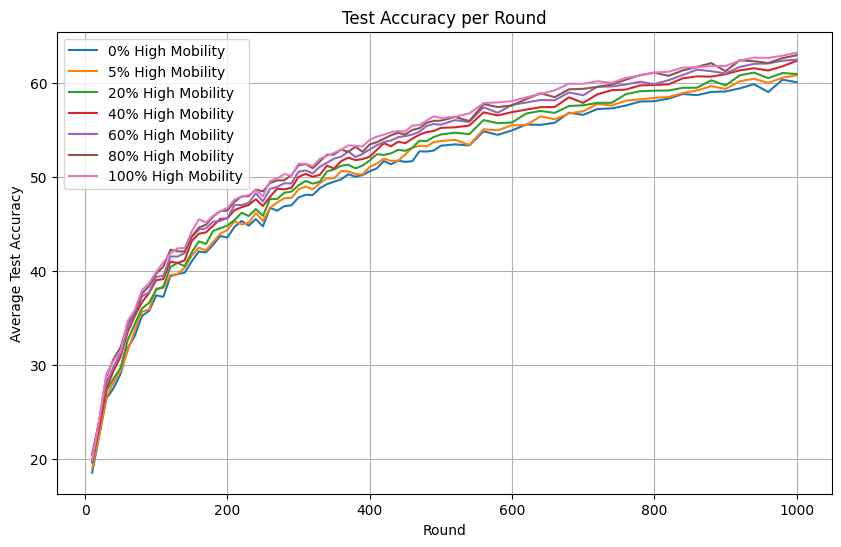

In [83]:
total_averages = inf_dict()

for experiment_group, averages in grouped_averages.items():
    for experiment, _ in averages.items():
        for statistic in statistics:
            for round, value in averages[experiment][statistic].items():
                if round not in total_averages[experiment][statistic]:
                    total_averages[experiment][statistic][round] = []
                total_averages[experiment][statistic][round].append(value)

print(total_averages)

for statistic in statistics:
    for experiment, _ in total_averages.items():
        for round, values in total_averages[experiment][statistic].items():
            total_averages[experiment][statistic][round] = np.mean(values)

plot_averages(experiments, total_averages, "Total", save_fig=True)

In [84]:
def plot_high_low_averages(high_average, low_average, statistic, experiment, prop_solution):
    plt.figure(figsize=(10, 6))


    rounds, acc_values = zip(*high_average[experiment][statistic].items())
    plt.plot(rounds, acc_values, label=f"High Mobility")

    rounds, acc_values = zip(*low_average[experiment][statistic].items())
    plt.plot(rounds, acc_values, label=f"Low Mobility")

    plt.xlabel("Round")
    plt.ylabel("Average Test Accuracy")
    plt.title(f"Test Accuracy per Round, {experiment * 100}% High-Mobility Clients,\n {'Not' if not prop_solution else ''} Mobility-Aware")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"saved_figures/test_accuracy_high_low_{experiment}_mobility_aware_{prop_solution}.pdf")
    plt.show()

def get_high_low_diff(high_average, low_average, statistic):
    differences = []
    for round in high_average[statistic]:
        differences.append(high_average[statistic][round] - low_average[statistic][round])
    return differences

def save_diff_analysis(mean, std, max, min, mobility_aware, experiment):
    file_name = "saved_figures/diff_analysis_mobility_aware.json"
    experiment = str(experiment)
    with open(file_name) as file:
        content = {}
        try:
            content = json.load(file)
        except Exception as e:
            print("error loading file", e)
        
        if experiment not in content:
            content[experiment] = {}
        
        key = "mobility_aware" if mobility_aware else "non_mobility_aware"
        if key not in content[experiment]:
            content[experiment][key] = {}

        content[experiment][key] = {
            "mean": mean,
            "std": std,
            "max": max,
            "min": min,
        }

        with open(file_name, "w") as file:
            json.dump(content, file)

if len(experiments) != 1:
    raise ValueError("Only one experiment can be plotted at a time")

high_mobility_averages = next(iter(grouped_high_mobility_averages.values()))
low_mobility_averages = next(iter(grouped_low_mobility_averages.values()))
experiment = next(iter(experiments.keys()))

plot_high_low_averages(high_mobility_averages, low_mobility_averages, "test_acc", experiment, mobility_aware)
diff = np.array(get_high_low_diff(high_mobility_averages[experiment], low_mobility_averages[experiment], "test_acc"))
diff.mean(), diff.std(), diff.max(), diff.min()
save_diff_analysis(diff.mean(), diff.std(), diff.max(), diff.min(), mobility_aware, experiment)

ValueError: Only one experiment can be plotted at a time